# Classification Models
***

In [1]:
%load_ext autoreload
%autoreload 2
from functions import *

In [2]:
# Import necessary libraries/packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import itertools
from sklearn import metrics

from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     RandomizedSearchCV, cross_val_score)

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
                              
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,
RandomForestRegressor)

from sklearn.metrics import (classification_report, confusion_matrix, 
                             plot_confusion_matrix, precision_score, 
                             accuracy_score, recall_score, f1_score, roc_curve, 
                             auc)

from scipy.special import logit

plt.style.use('seaborn')

import shap
shap.initjs()

from alibi.explainers import KernelShap
from scipy.special import logit

from sklearn.feature_extraction.text import TfidfVectorizer

***
# Preprocessing data
***

In [3]:
# Load dataset and ceate pd dataframes
new_df = pd.read_csv('../DATA/1950up_df.csv')

In [4]:
new_df.describe().round(2)

,Unnamed: 0,valence,year,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,popularity,speechiness,tempo
count,140600.00,140600.00,140600.00,140600.00,140600.00,140600.00,140600.00,140600.00,140600.00,140600.00,140600.00,140600.00,140600.00,140600.00
mean,91084.84,0.53,1985.01,0.43,0.54,235680.70,0.53,0.13,5.19,0.20,-10.67,37.73,0.08,118.49
std,48234.99,0.26,20.47,0.36,0.18,117960.66,0.26,0.28,3.52,0.18,5.40,18.62,0.10,30.37
min,5606.00,0.00,1950.00,0.00,0.00,8853.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00
25%,50149.75,0.32,1967.00,0.07,0.42,174973.00,0.32,0.00,2.00,0.10,-13.51,25.00,0.03,95.09
50%,92015.50,0.54,1985.00,0.37,0.55,216627.00,0.54,0.00,5.00,0.13,-9.74,39.00,0.04,116.18
75%,133261.25,0.75,2003.00,0.78,0.67,268827.00,0.74,0.03,8.00,0.26,-6.67,51.00,0.07,137.28
max,170652.00,1.00,2020.00,1.00,0.99,5403500.00,1.00,1.00,11.00,1.00,3.74,100.00,0.97,243.51


In [5]:
new_df.shape

(140600, 16)

## Popularity Distribution
Using classification models, I want to predict the popularity of a song given the features of tha data set. This data set includes a column for song popularity, which is ranges from 0-100, with 100 being the most popular. I will plot the popularity distribution of these scores. 

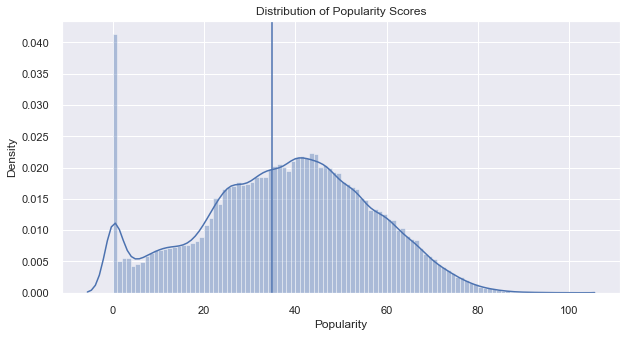

In [6]:
fig = plt.figure(figsize=(10,5))
sns.set(style="darkgrid") 
sns.distplot(new_df['popularity'], label="Popularity", bins='auto')
plt.xlabel("Popularity")
plt.ylabel("Density")
plt.title("Distribution of Popularity Scores")
plt.axvline(35)
plt.show()

## Create caterogrical (binary) target
In order to create a variable to be the target of this classification analysis, I decided to use a popularity of 35 as a threshold value. In this step, I will create a new binary column named "popular". This column will have a threshold of 35 popularity. If the song popularity is greater than or equal to 35, then it will be classified a popular song (1). Otherwise, the song is not popular (0). I will build other models that have different threshold values and compare model performance.

In [7]:
new_df['popular'] = (new_df['popularity'] >= 35).astype('int')
new_df['popular'].value_counts(1)

1    0.585313
0    0.414687
Name: popular, dtype: float64

In [8]:
new_df.head()

,Unnamed: 0,valence,year,acousticness,artists,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,name,popularity,speechiness,tempo,popular
0,5606,0.197,1950,0.990,['Ella Fitzgerald'],0.354,196667,0.0851,0.000004,7,0.1230,-13.738,Someone To Watch Over Me,56,0.0345,97.684,1
1,5607,0.258,1950,0.986,['Ella Fitzgerald'],0.455,196440,0.1060,0.000000,2,0.1220,-14.086,I've Got A Crush On You,55,0.0422,66.807,1
2,5608,0.345,1950,0.960,['Hoagy Carmichael'],0.658,146347,0.0542,0.106000,8,0.1060,-19.427,Stardust,42,0.0596,90.138,1
3,5609,0.951,1950,0.830,['Lefty Frizzell'],0.545,179307,0.3920,0.000094,2,0.0903,-10.091,If You've Got the Money I've Got the Time,43,0.0481,208.426,1
4,5610,0.540,1950,0.958,"['Dean Martin', 'Paul Weston And His Orchestra']",0.498,155107,0.2210,0.053000,5,0.2220,-11.750,Powder Your Face With Sunshine (Smile! Smile! ...,37,0.0450,168.748,1


In [9]:
# Save raw dataframe with 'popular column' as csv file and store in DATA folder
new_df.to_csv('../DATA/new1950_df.csv') 

## Make a new dataframe with necessary information

In [10]:
df = new_df[['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
             'energy', 'instrumentalness', 'liveness', 'loudness', 
          'speechiness', 'tempo', 'key', 'popular']]

In [11]:
df.head()

,valence,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,key,popular
0,0.197,1950,0.990,0.354,196667,0.0851,0.000004,0.1230,-13.738,0.0345,97.684,7,1
1,0.258,1950,0.986,0.455,196440,0.1060,0.000000,0.1220,-14.086,0.0422,66.807,2,1
2,0.345,1950,0.960,0.658,146347,0.0542,0.106000,0.1060,-19.427,0.0596,90.138,8,1
3,0.951,1950,0.830,0.545,179307,0.3920,0.000094,0.0903,-10.091,0.0481,208.426,2,1
4,0.540,1950,0.958,0.498,155107,0.2210,0.053000,0.2220,-11.750,0.0450,168.748,5,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140600 entries, 0 to 140599
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           140600 non-null  float64
 1   year              140600 non-null  int64  
 2   acousticness      140600 non-null  float64
 3   danceability      140600 non-null  float64
 4   duration_ms       140600 non-null  int64  
 5   energy            140600 non-null  float64
 6   instrumentalness  140600 non-null  float64
 7   liveness          140600 non-null  float64
 8   loudness          140600 non-null  float64
 9   speechiness       140600 non-null  float64
 10  tempo             140600 non-null  float64
 11  key               140600 non-null  int64  
 12  popular           140600 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 13.9 MB


# Logistic Regression Models
***

## LR Model 1: Baseline model

### Define X and y

In [13]:
X = df[['valence', 'acousticness', 'danceability', 'duration_ms',
             'energy', 'instrumentalness', 'liveness', 'loudness', 
          'speechiness', 'tempo', 'key']]

y = df['popular']

### Train Test Split

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)

### Standardize train and test sets

In [15]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns,
                       index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns,
                      index=X_test.index)

In [16]:
X_train.describe()

,valence,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,key
count,1.054500e+05,1.054500e+05,1.054500e+05,1.054500e+05,1.054500e+05,1.054500e+05,1.054500e+05,1.054500e+05,1.054500e+05,1.054500e+05,1.054500e+05
mean,7.081844e-17,-8.166693e-17,4.056394e-17,-4.366351e-17,3.653450e-16,1.482403e-17,-7.331157e-17,1.699373e-16,5.188411e-17,1.704764e-16,-1.142798e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-2.006653e+00,-1.199262e+00,-3.085270e+00,-1.879310e+00,-2.025664e+00,-4.641580e-01,-1.146202e+00,-9.120831e+00,-7.465715e-01,-3.902647e+00,-1.474058e+00
25%,-8.040687e-01,-1.015108e+00,-6.707372e-01,-5.050485e-01,-8.015712e-01,-4.641580e-01,-6.029820e-01,-5.264456e-01,-4.229915e-01,-7.708338e-01,-9.056450e-01
50%,3.053248e-02,-1.644509e-01,5.248361e-02,-1.607704e-01,2.851679e-02,-4.638289e-01,-4.049330e-01,1.726953e-01,-3.342217e-01,-7.479740e-02,-5.302496e-02
75%,8.347846e-01,9.886246e-01,7.187579e-01,2.714597e-01,8.203519e-01,-3.640127e-01,2.910677e-01,7.409206e-01,-8.413917e-02,6.202181e-01,7.995951e-01
max,1.786989e+00,1.605288e+00,2.541047e+00,4.270953e+01,1.799626e+00,3.087091e+00,4.512340e+00,2.666008e+00,8.502664e+00,4.116454e+00,1.652215e+00


### Instantiate classifier and fit

In [17]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

### Predict

In [18]:
pred = logreg.predict(X_test)

### Summary Plot Mean absolute error of each feature

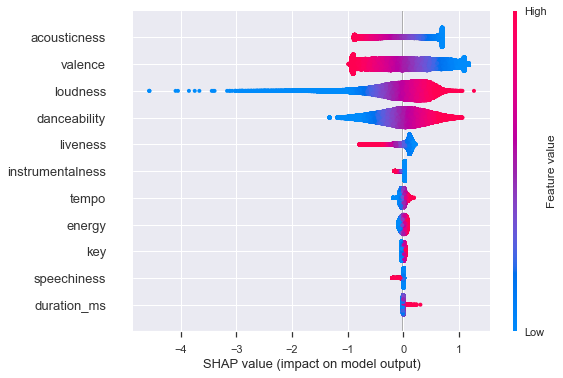

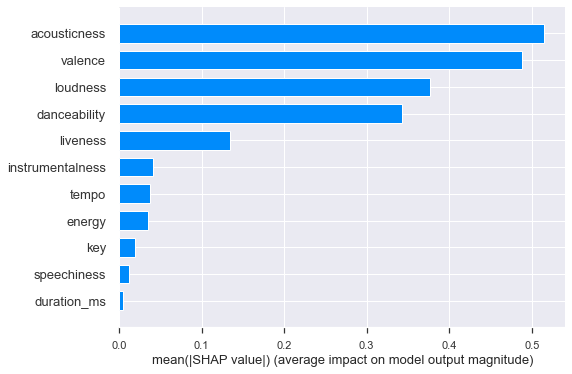

In [19]:
plot_shap(logreg, X_train)

X-axis: does it help the model more towards the positive outcome (popular) or negative outcome (not popular).

The newer songs are often more popular 

### Model coefficients
"Generally, positive coefficients make the event more likely and negative coefficients make the event less likely. An estimated coefficient near 0 implies that the effect of the predictor is small."

“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) when all other variables are held constant.”

In [20]:
find_coeffs(logreg, X_train, X).style.background_gradient(cmap='coolwarm')

,coef
loudness,0.495175
danceability,0.424591
tempo,0.046833
energy,0.041419
key,0.021756
duration_ms,0.007218
speechiness,-0.023178
instrumentalness,-0.054106
liveness,-0.179608
acousticness,-0.566818


### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.69      0.59      0.63     14724
     Popular       0.73      0.81      0.77     20426

    accuracy                           0.72     35150
   macro avg       0.71      0.70      0.70     35150
weighted avg       0.71      0.72      0.71     35150



----------------------------------------------------------
Training Accuracy Score: 71.67%
Testing Accuracy Score: 71.55%
Accuracy: 71.55%


----------------------------------------------------------


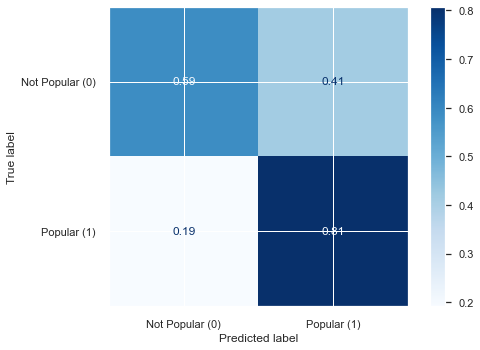

In [21]:
model_performance(logreg, X_train, X_test, y_train, y_test, pred)

Notes:
* Model has accuracy of 84% 
* Issues predicting popular songs. Too many false negatives and false positives

### ROC Curve and AUC
"ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s."

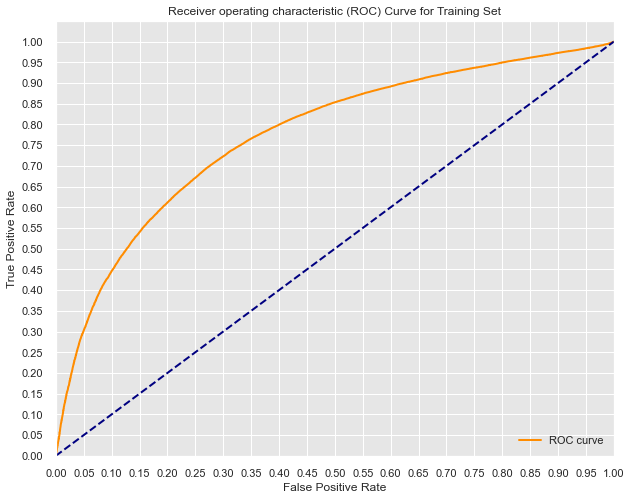

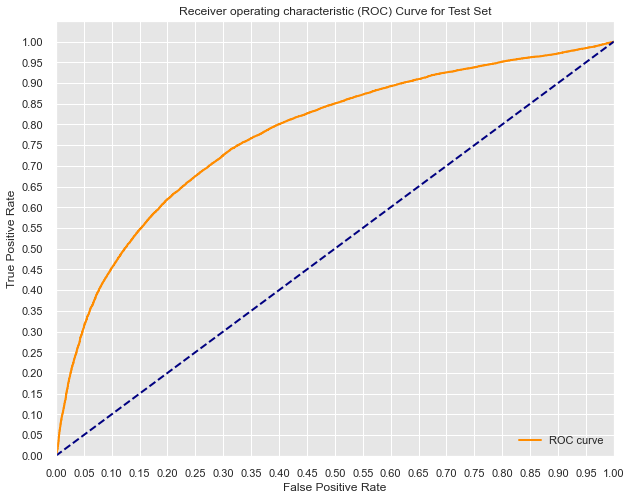

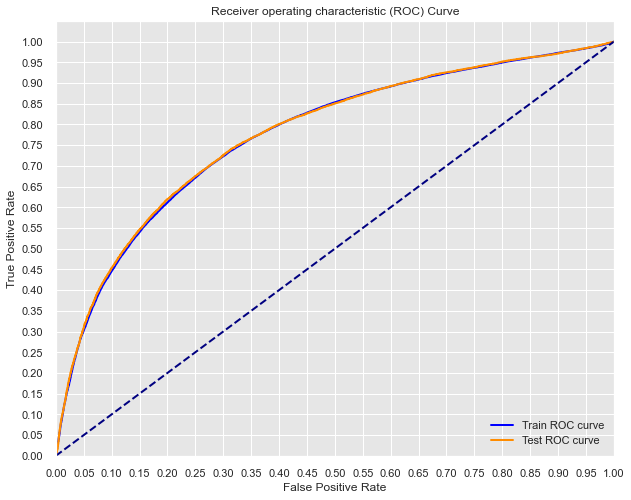

Train AUC: 0.773984789010887
Test AUC: 0.7758296455160075


In [22]:
roc_auc(logreg, X_train, X_test, y_train, y_test)

AUC is looking pretty good but could be better. Also the ROC curve could be more perpendicular

***
## LR Model 2: LogisticRegressionCV

### Instantiate classifier and fit model

In [23]:
logregcv = LogisticRegressionCV()
logregcv.fit(X_train, y_train)

LogisticRegressionCV()

### Predict

In [24]:
pred = logregcv.predict(X_test)

### Summary Plot and Mean absolute error 

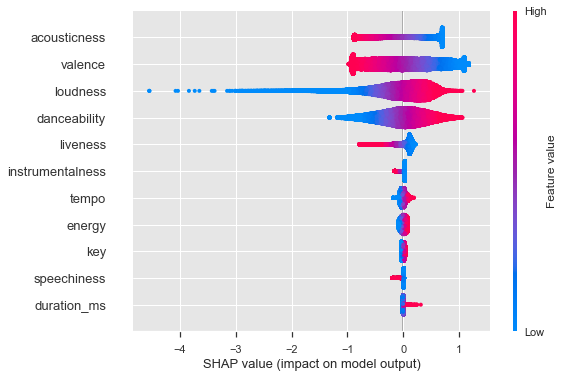

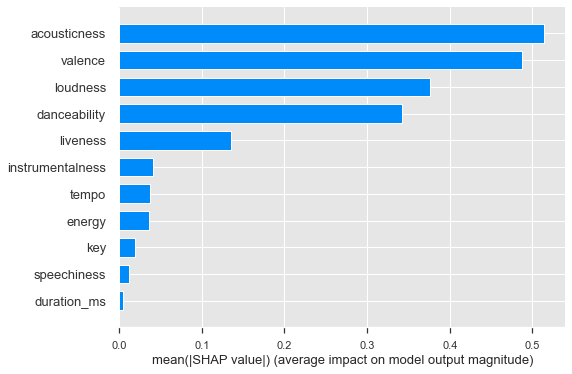

In [25]:
plot_shap(logregcv, X_train)

### Model  coefficients

In [26]:
find_coeffs(logregcv, X_train, X).style.background_gradient(cmap='coolwarm')

,coef
loudness,0.493602
danceability,0.423482
tempo,0.046581
energy,0.042927
key,0.021729
duration_ms,0.007365
speechiness,-0.023098
instrumentalness,-0.054463
liveness,-0.179637
acousticness,-0.565647


### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.69      0.59      0.63     14724
     Popular       0.73      0.81      0.77     20426

    accuracy                           0.72     35150
   macro avg       0.71      0.70      0.70     35150
weighted avg       0.71      0.72      0.71     35150



----------------------------------------------------------
Training Accuracy Score: 71.66%
Testing Accuracy Score: 71.54%
Accuracy: 71.54%


----------------------------------------------------------


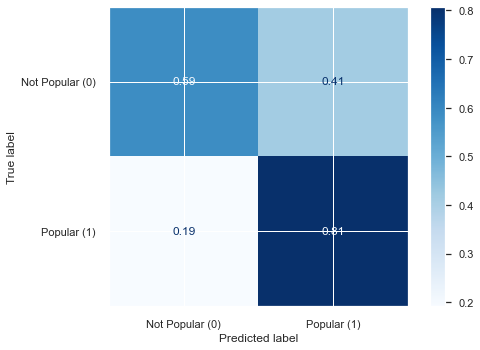

In [27]:
model_performance(logregcv, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

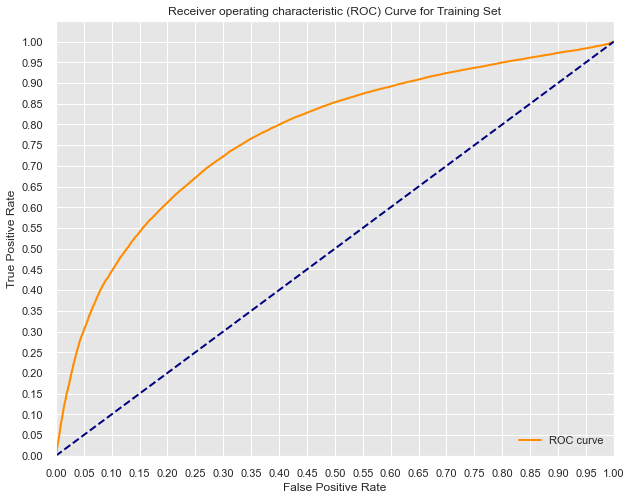

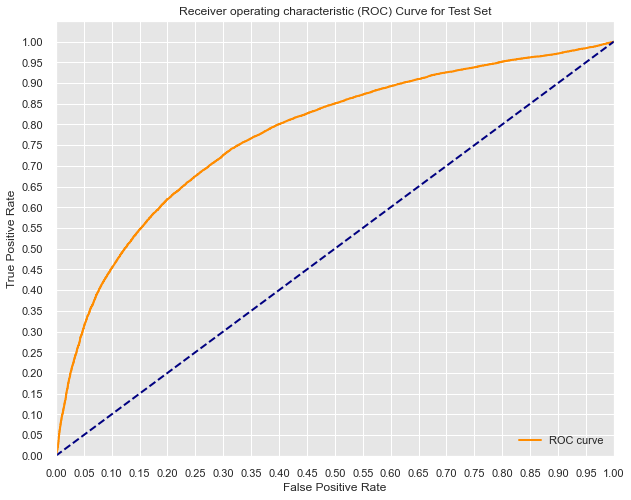

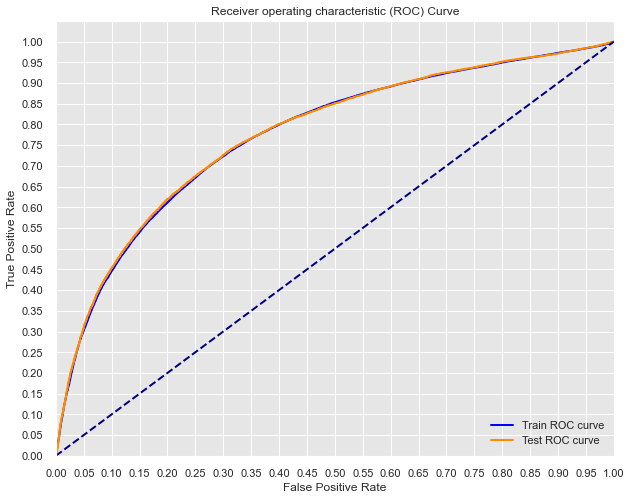

Train AUC: 0.7739803193886672
Test AUC: 0.7758256388982587


In [28]:
roc_auc(logregcv, X_train, X_test, y_train, y_test)

***
## LR Model 3: GridSearchCV

### Instantiate classifier

In [29]:
logreg = LogisticRegression()

### Create Parameter Grid 

In [30]:
log_param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

### Instantiate GridSearchCV and fit

In [31]:
gs_log = GridSearchCV(logreg, log_param_grid, cv=3, return_train_score=True,
                      n_jobs=-1)

In [32]:
gs_log.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             return_train_score=True)

### Best parameters

In [33]:
print("Best Parameter Combination Found During Grid Search:")
gs_log.best_params_

Best Parameter Combination Found During Grid Search:


{'C': 0.01, 'penalty': 'l2'}

### Predict

In [34]:
pred = gs_log.predict(X_test)

### Summary Plot Mean absolute error of each feature

In [35]:
#plot_shap(gs_log, X_train)

### Model coefficients

In [36]:
# find_coeffs(gs_log, X_train, X).style.background_gradient(cmap='coolwarm')

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.69      0.59      0.63     14724
     Popular       0.73      0.81      0.77     20426

    accuracy                           0.72     35150
   macro avg       0.71      0.70      0.70     35150
weighted avg       0.71      0.72      0.71     35150



----------------------------------------------------------
Training Accuracy Score: 71.66%
Testing Accuracy Score: 71.54%
Accuracy: 71.54%


----------------------------------------------------------


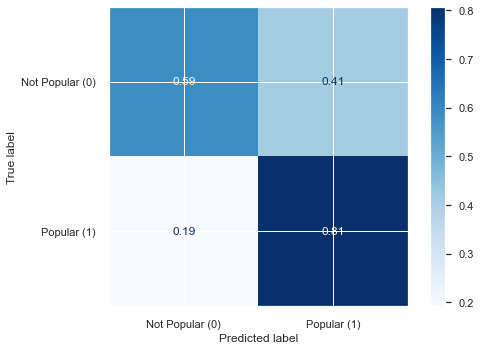

In [37]:
model_performance(gs_log, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

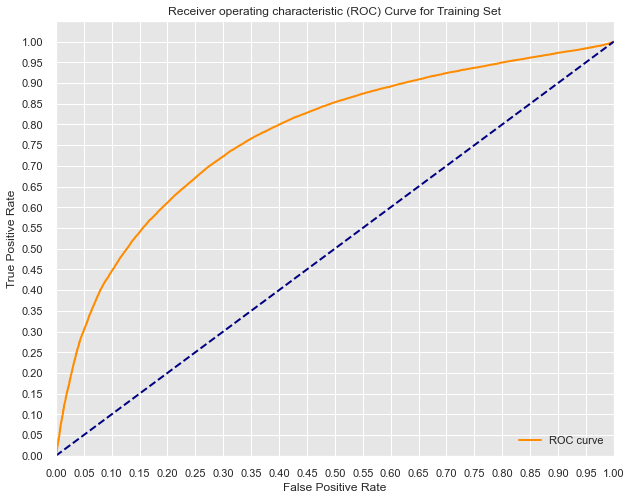

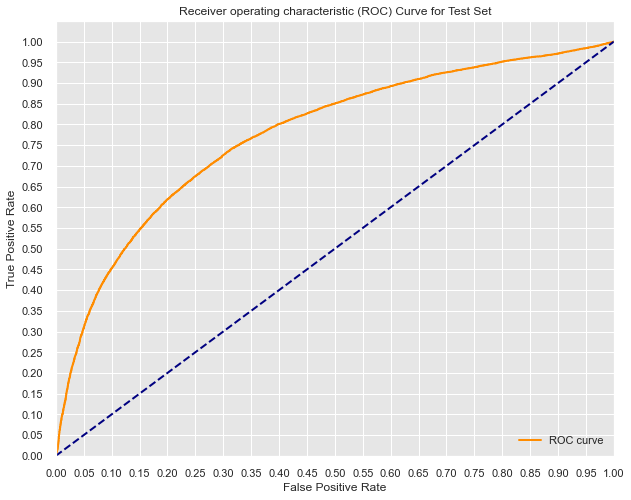

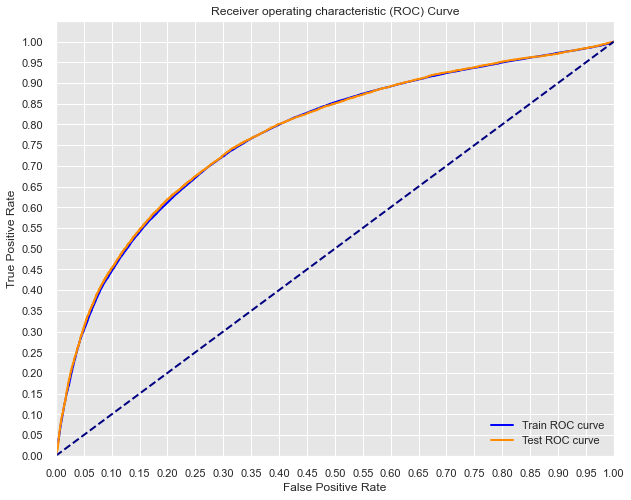

Train AUC: 0.7739715347998695
Test AUC: 0.7758126082468415


In [38]:
roc_auc(gs_log, X_train, X_test, y_train, y_test)

***
# Decision Trees Models
***

## DT Model 1: Baseline DecisionTree Model

### Instantiate classifier and fit model

In [39]:
dtree_clf = DecisionTreeClassifier() 
dtree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

### Predict

In [40]:
pred = dtree_clf.predict(X_test)

### Model coefficients

In [41]:
#find_coeffs(dtree_clf, X_train, X).style.background_gradient(cmap='coolwarm')

### Model Performance

In [42]:
#model_performance(dtree_clf, X_train, X_test, y_train, y_test, pred)

### Feature Importances

loudness            0.210410
acousticness        0.128262
duration_ms         0.100348
danceability        0.085526
valence             0.083395
liveness            0.076089
speechiness         0.076050
tempo               0.072712
energy              0.070619
instrumentalness    0.064443
key                 0.032145
dtype: float64

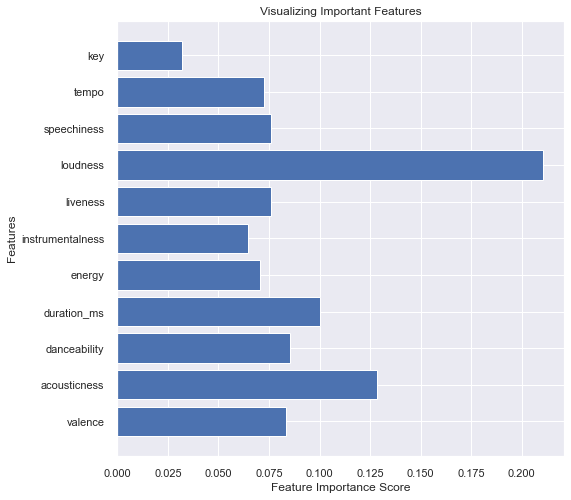

In [43]:
plot_feature_importances(dtree_clf, X_train, X)

### ROC Curve and AUC

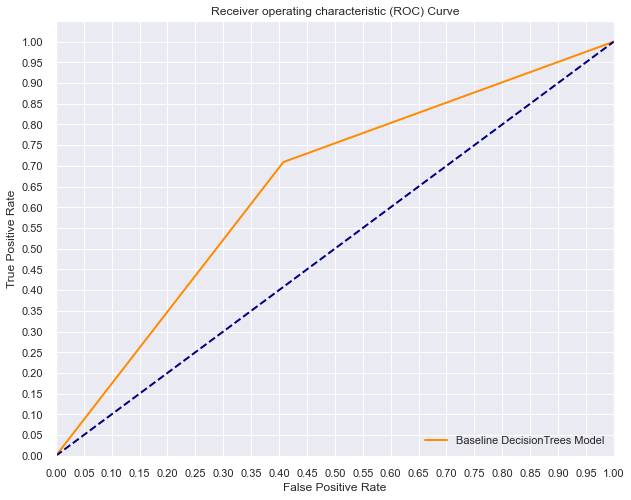

AUC: 0.6506933091252491


In [44]:
label = 'Baseline DecisionTrees Model'

roc_dt_rf(y_test, pred, label=label)

***
## DT Model 2: Bagged DecisionTree

### Instantiate classifier and fit

In [45]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier())
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier())

### Predict

In [46]:
pred = bagged_tree.predict(X_test)

### Model coefficients

In [47]:
#find_coeffs(bagged_tree, X_train, X).style.background_gradient(cmap='coolwarm')

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.65      0.70      0.67     14724
     Popular       0.77      0.73      0.75     20426

    accuracy                           0.72     35150
   macro avg       0.71      0.71      0.71     35150
weighted avg       0.72      0.72      0.72     35150



----------------------------------------------------------
Training Accuracy Score: 98.39%
Testing Accuracy Score: 71.6%
Accuracy: 71.6%


----------------------------------------------------------


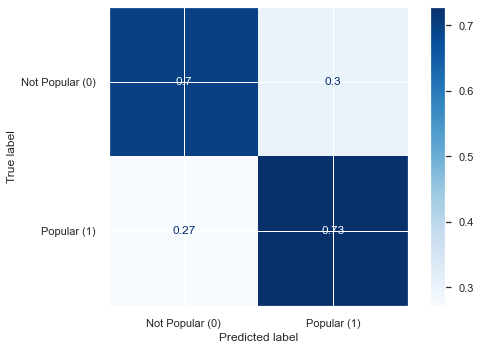

In [48]:
model_performance(bagged_tree, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

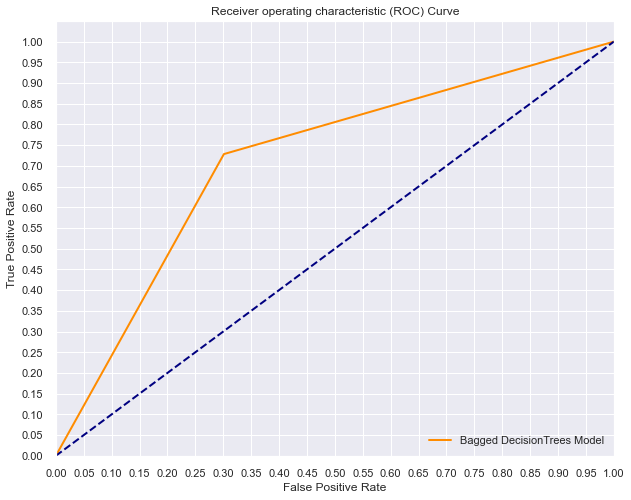

AUC: 0.7136371974844


In [49]:
label = 'Bagged DecisionTrees Model'

roc_dt_rf(y_test, pred, label=label)

***
## DT Model 3: DecisionTree GridSearch 

### Instantiate classifier

In [50]:
dtree_model = DecisionTreeClassifier() 

### Create Parameter Grid

In [51]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 6]
}

### Instantiate GridSearchCV and fit

In [52]:
dt_grid_search = GridSearchCV(dtree_model, dt_param_grid, cv=3,
                              return_train_score=True, n_jobs=-1)

In [53]:
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10],
                         'min_samples_leaf': [2, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

### Best parameters

In [54]:
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

### Predict

In [55]:
pred = dt_grid_search.predict(X_test)

### Model coefficients

In [56]:
#find_coeffs(dt_grid_search, X_train, X).style.background_gradient(cmap='coolwarm')

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.67      0.66      0.66     14724
     Popular       0.76      0.76      0.76     20426

    accuracy                           0.72     35150
   macro avg       0.71      0.71      0.71     35150
weighted avg       0.72      0.72      0.72     35150



----------------------------------------------------------
Training Accuracy Score: 74.84%
Testing Accuracy Score: 71.8%
Accuracy: 71.8%


----------------------------------------------------------


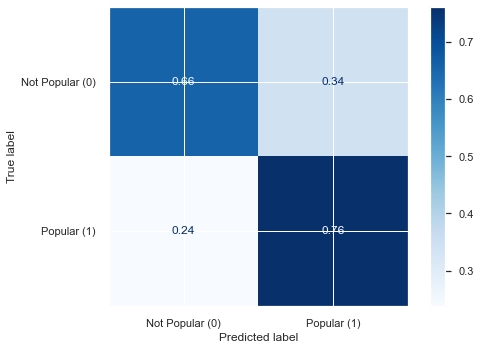

In [57]:
model_performance(dt_grid_search, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

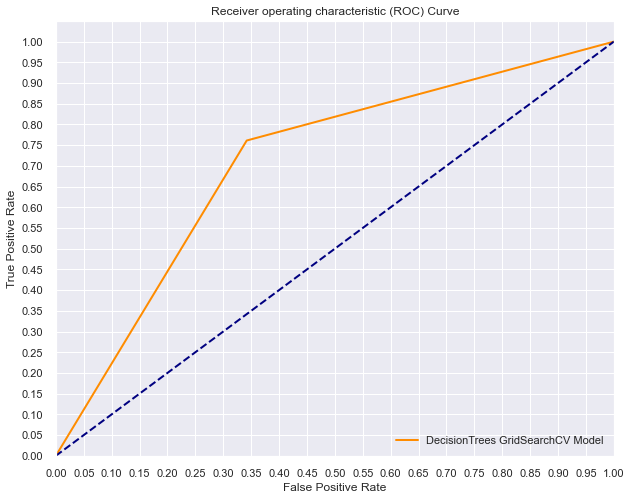

AUC: 0.7095705702441821


In [58]:
label = 'DecisionTrees GridSearchCV Model'

roc_dt_rf(y_test, pred, label=label)

***
# Random Forests Models
***

## RF Model 1: Baseline Model

### Instantiate classifier and fit

In [59]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

### Predict

In [60]:
pred = forest.predict(X_test)

### Summary Plot Mean absolute error of each feature

In [61]:
# plot_shap_tree(forest, X_train)

### Model coefficients

In [62]:
# find_coeffs(forest, X_train, X).style.background_gradient(cmap='coolwarm')

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.69      0.67      0.68     14724
     Popular       0.77      0.79      0.78     20426

    accuracy                           0.74     35150
   macro avg       0.73      0.73      0.73     35150
weighted avg       0.74      0.74      0.74     35150



----------------------------------------------------------
Training Accuracy Score: 99.67%
Testing Accuracy Score: 73.9%
Accuracy: 73.9%


----------------------------------------------------------


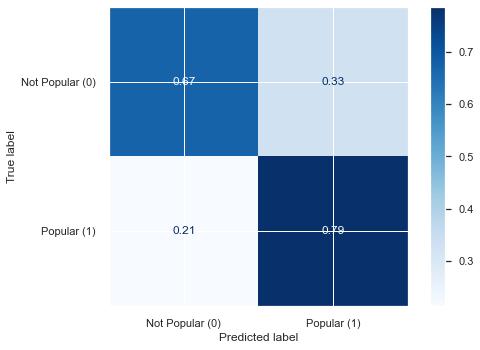

In [63]:
model_performance(forest, X_train, X_test, y_train, y_test, pred)

Notes:
* Model has accuracy of 85% 
* Issues predicting popular songs. Too many false negatives and false positives

### ROC Curve and AUC

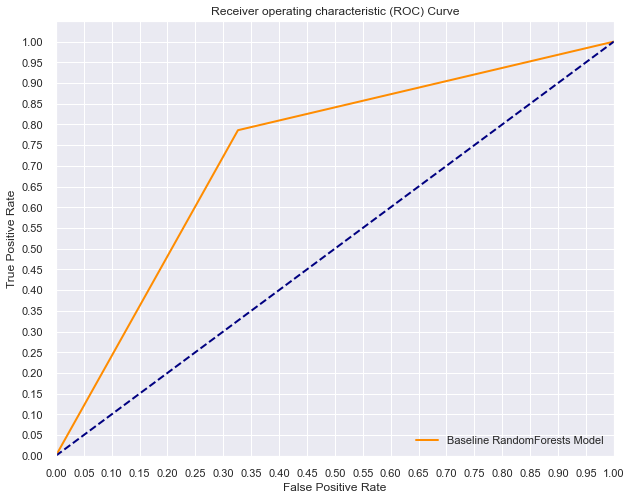

AUC: 0.7298745163231004


In [64]:
label = 'Baseline RandomForests Model'
roc_dt_rf(y_test, pred, label=label)

***
## RF Model 2: GridSearchCV Model

### Instantiate classifier

In [65]:
rforest_model = RandomForestClassifier()

### Create Parameter Grid

In [66]:
rf_param_grid = {
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

### Instantiate GridSearchCV and fit

In [67]:
rf_grid_search = GridSearchCV(rforest_model, rf_param_grid, cv=3,
                            return_train_score=True, n_jobs=-1)

In [68]:
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5], 'min_samples_leaf': [3, 6],
                         'min_samples_split': [5, 10],
                         'n_estimators': [10, 100]},
             return_train_score=True)

### Best parameters

In [69]:
print("Best Parameter Combination Found During Grid Search:")
rf_grid_search.best_params_

Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 100}

### Predict

In [70]:
pred = rf_grid_search.predict(X_test)

### Model coefficients

In [71]:
#find_coeffs(rf_grid_search, X_train, X).style.background_gradient(cmap='coolwarm')

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.70      0.67      0.69     14724
     Popular       0.77      0.79      0.78     20426

    accuracy                           0.74     35150
   macro avg       0.74      0.73      0.73     35150
weighted avg       0.74      0.74      0.74     35150



----------------------------------------------------------
Training Accuracy Score: 97.03%
Testing Accuracy Score: 74.28%
Accuracy: 74.28%


----------------------------------------------------------


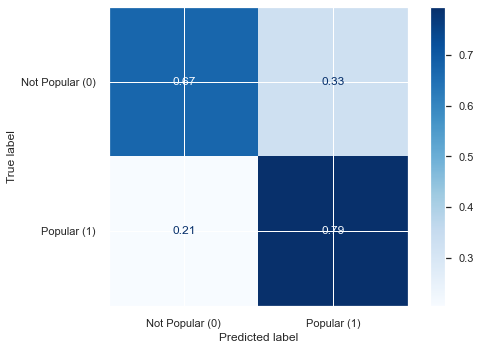

In [72]:
model_performance(rf_grid_search, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

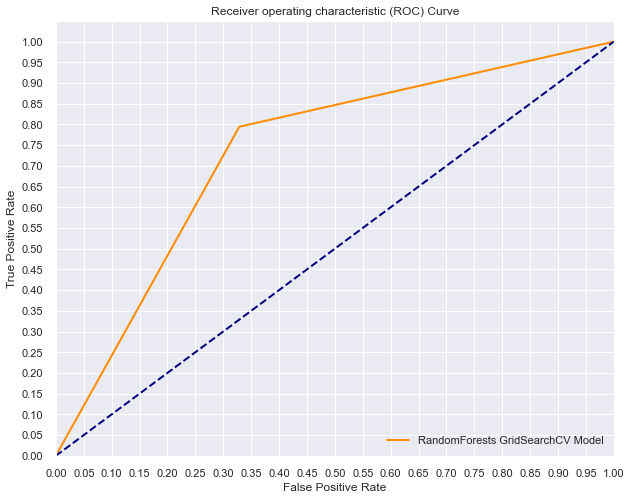

AUC: 0.7328378640100337


In [73]:
label = 'RandomForests GridSearchCV Model'

roc_dt_rf(y_test, pred, label=label)